In [1]:
!pip install pandas scikit-learn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from include.utils import incrementar_dados_aleatorios_csv, categorizar_imc, dados_especificos_coluna
from include.graficos import montar_graficos_visualizacao_inicial, montar_grafico_correlacao, montar_graficos_relacionamento_encargos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

**1. Definição do Problema de Negócios**

**Contexto do Problema:**

O contexto do problema é a construção de um modelo preditivo para prever os custos médicos individuais cobrados pelo seguro de saúde.
Isso envolve analisar um conjunto de dados que contém informações sobre características individuais, como idade, gênero, IMC (índice de massa corporal), número de filhos, fumante ou não, região, entre outros, e os custos médicos correspondentes.

**Objetivos da Análise:**

- Considerar na escolha do modelo aquele que entregar a melhor acurácia.
- Desenvolver um modelo preditivo que possa fazer previsões confiáveis dos custos médicos individuais com base nas características fornecidas.
- Avaliar a importância das diferentes características no modelo de previsão de custos médicos.
- Identificar padrões e relacionamentos nos dados que possam ajudar a melhorar a precisão das previsões.
- Fornecer insights para ajudar a entender os principais fatores que influenciam os custos médicos individuais.

**Perguntas de Negócios:**

- Quais características individuais têm maior impacto nos custos médicos cobrados pelo seguro de saúde?
- Existe alguma correlação entre certas características (por exemplo, idade, IMC) e os custos médicos?
- O número de filhos influencia significativamente nos custos médicos?
- Há uma diferença significativa nos custos médicos entre fumantes e não fumantes?
- Como o modelo pode ser utilizado para prever e planejar os custos médicos futuros?

**Benefícios Esperados:**

- Melhor compreensão dos fatores que contribuem para os custos médicos individuais.
- Desenvolvimento de um modelo preditivo preciso que possa ser usado para prever custos médicos futuros com base em diferentes características individuais.
- Melhoria na precificação do seguro de saúde, permitindo uma cobrança mais precisa e justa dos prêmios.
- Potencial economia de custos para seguradoras e segurados, evitando subestimação ou superestimação dos custos médicos.

**Descrição dos dados disponíveis**
    
Os dados disponíveis consistem em um conjunto de informações sobre segurados de um plano de saúde. Cada entrada no conjunto de dados contém as seguintes características:

- **Idade (int):** A idade do segurado.
- **Gênero (string):** O gênero do segurado (masculino ou feminino).
- **IMC (float):** O índice de massa corporal do segurado.
- **Número de Filhos (int):** O número de filhos do segurado.
- **Fumante (string):** Indicação se o segurado é fumante ou não.
- **Região (string):** A região geográfica onde o segurado reside.
- **Encargos (float):** Os custos médicos individuais cobrados pelo seguro de saúde.

Durante o processamento, os dados são salvos em 4 planilhas (pasta planilhas):
- **1_dados_originais.csv:** Esta planilha representa um "pequeno universo" de dados. No caso alimentei apenas com os dados mencionados no Tech Challenge do site da FIAP
- **2_dados_aleatorios_sobre_original.csv:** Esta planilha é gerada já no início do código para alimentar mais dados da planilha original, incrementar no dataset original, e além disso seus dados foram embaralhados, com colunas com dados nan (pra serem tratados mais a frente)
- **3_dados_processados_treino.csv:** Esta planilha é gerada na etapa "Separação dos Dados em Treino e Teste". Nesta planilha estão contidos o conjunto dos treinos
- **4_dados_processados_teste.csv:** Esta planilha é gerada na etapa "Separação dos Dados em Treino e Teste". Nesta planilha estão contidos o conjunto dos testes
- **5_dados_processados_treino_target.csv:** Esta planilha é gerada na etapa "Separação dos Dados em Treino e Teste". Nesta planilha estão contidos os alvos dos treinos
- **6_dados_processados_teste_target.csv:** Esta planilha é gerada na etapa "Separação dos Dados em Treino e Teste". Nesta planilha estão contidos os alvos dos testes
- **7_dados_com_outliers.csv:** Esta planilha demostra os outliers para cada coluna
- **8_dados_futuros.csv:** Esta planilha é gerada para realizar previsões futuras, após escolha do melhor modelo

Esses dados serão utilizados para desenvolver um modelo preditivo para prever os custos médicos individuais com base nas características fornecidas. Para alcançar esse objetivo, a avaliação dos modelos será realizada com base em métricas como R² (coeficiente de determinação) e MAE (erro absoluto médio) para medir a acurácia dos modelos. A seleção do melhor modelo será feita com base na acurácia média com validação cruzada, e a otimização de hiperparâmetros será direcionada para maximizar a acurácia do modelo selecionado.

**2. Análise dos Dados**

**Sumário dos Dados:**

In [3]:
# leia os dados CSV indicados no site da FIAP (foi incluído manualmente algumas poucas linhas)
dados = pd.read_csv('../planilhas/1_dados_originais.csv', encoding='latin-1')

novas_linhas = 10000
quantidade_maxima_ausencias = 80

# aqui chamo a função incrementar_dados_aleatorios, para aumentar o volume da variável dados
# uso duas variáveis, uma para incrementar a quantidade de linhas e outra para limitar a quantidade máxima de ausências (dados = np.nan)
dados = incrementar_dados_aleatorios_csv(dados, novas_linhas, quantidade_maxima_ausencias)

# Criar uma nova coluna 'Categoria_IMC' depois da coluna 'IMC'
dados.insert(dados.columns.get_loc('IMC') + 1, 'Categoria_IMC', dados['IMC'].apply(categorizar_imc))

# Criando mais uma coluna fumante_numero, para usar mais pra frente na correlação (depois será removido)
mapeamento_fumante = dados['Fumante'].map({'sim': 1, 'não': 0})

# Criar uma nova coluna 'Fumante_Numero' antes da coluna 'Encargos'
dados.insert(dados.columns.get_loc('Encargos'), 'Fumante_Numero', mapeamento_fumante)

print("\nLista de todas colunas:\n\n", list(dados))
print("\nAmostra dos dados:\n\n", dados.head())
print(f"\nQuantidade de linhas: {dados.shape[0]}. Quantidade de colunas: {dados.shape[1]}")
print("\nTipos de dados das colunas:\n\n", dados.dtypes)
print("\nQuantidade de valores ausentes por coluna:\n\n", dados.isnull().sum())


Lista de todas colunas:

 ['Idade', 'Gênero', 'IMC', 'Categoria_IMC', 'Filhos', 'Fumante', 'Região', 'Fumante_Numero', 'Encargos']

Amostra dos dados:

    Idade     Gênero    IMC Categoria_IMC  Filhos Fumante    Região  \
0   56.0   feminino  29.77     Sobrepeso     2.0     sim  sudoeste   
1   46.0  masculino  25.86     Sobrepeso     1.0     não  nordeste   
2   32.0  masculino  43.01         Obeso     0.0     não  sudoeste   
3   27.0   feminino  26.01     Sobrepeso     3.0     não  noroeste   
4   19.0  masculino  28.01     Sobrepeso     2.0     não   sudeste   

   Fumante_Numero  Encargos  
0             1.0  31109.89  
1             0.0  26650.70  
2             0.0  21059.04  
3             0.0  21459.04  
4             0.0  41659.04  

Quantidade de linhas: 10009. Quantidade de colunas: 9

Tipos de dados das colunas:

 Idade             float64
Gênero             object
IMC               float64
Categoria_IMC      object
Filhos            float64
Fumante            object
Reg

**Visualização dos Dados:** gráficos para entender a distribuição e padrões nos dados.

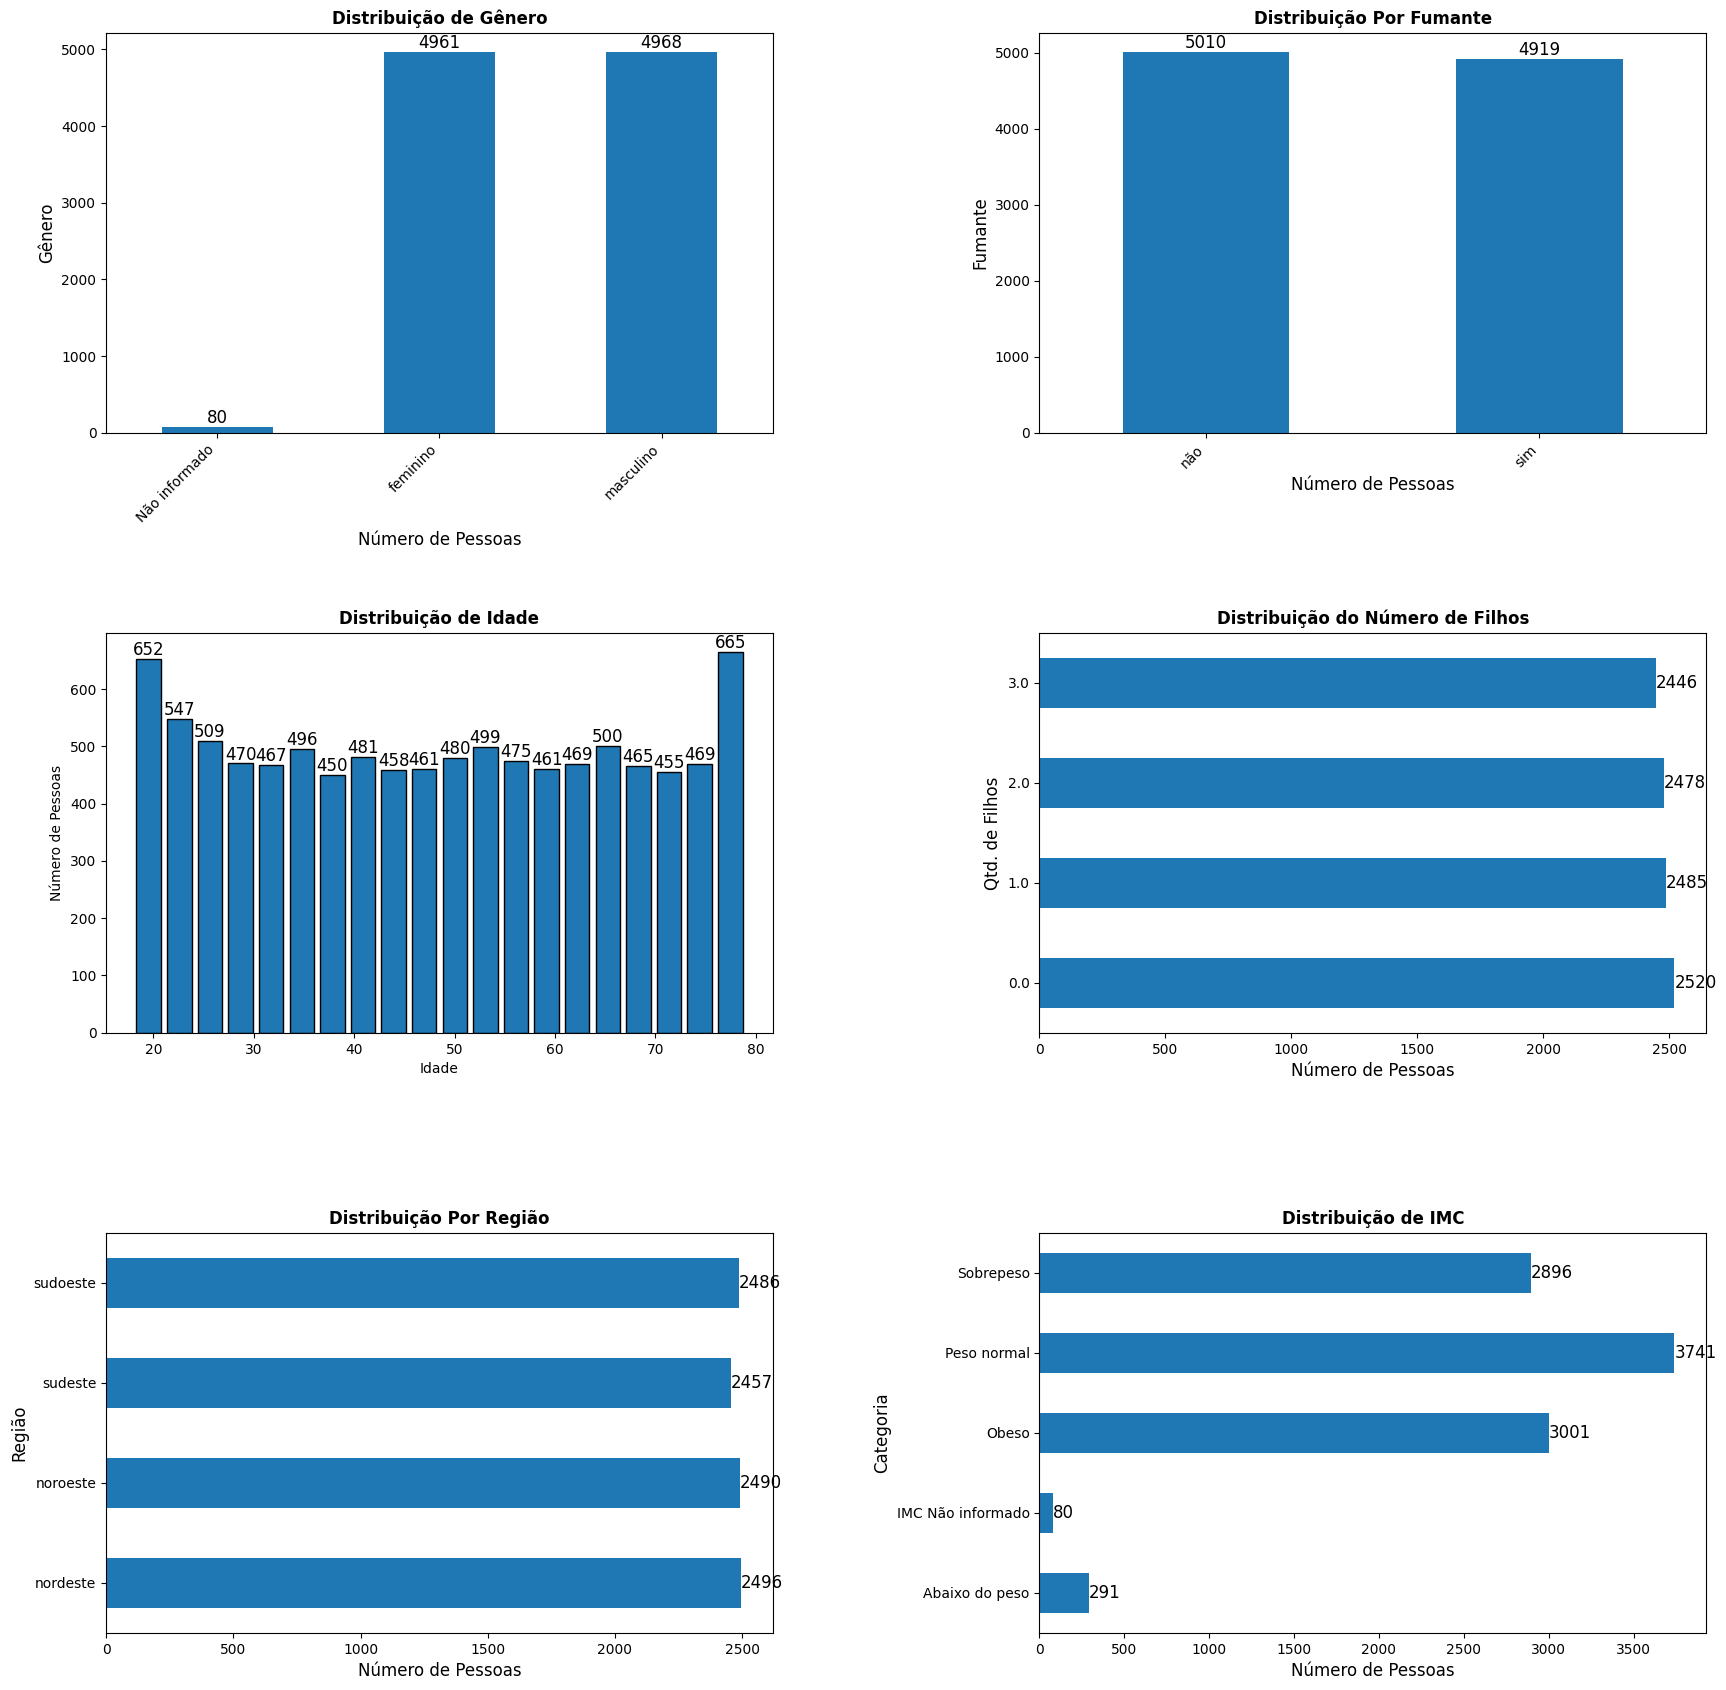

In [4]:
montar_graficos_visualizacao_inicial(dados)

**3. Separação dos Dados em Treino e Teste**

In [5]:
# Dividir os dados em features (X) e target (y)
X = dados.drop(['Encargos','Gênero','Região','Categoria_IMC','Fumante_Numero'], axis=1)  # descartando colunas não necessárias para o teste
colunas_descartadas = dados[['Gênero','Região','Categoria_IMC']]

y = dados['Encargos']

# Codificar variáveis com LabelEncoder
label_encoder = LabelEncoder()
X['Fumante'] = label_encoder.fit_transform(X['Fumante'])

# Substituir valores 'sim' e 'não' por 1 e 0 (comentei porque o resultado é o mesmo no LabelEncoder
#X['Fumante'] = X['Fumante'].map({'sim': 1, 'não': 0})

print(X)

       Idade    IMC  Filhos  Fumante
0       56.0  29.77     2.0        1
1       46.0  25.86     1.0        0
2       32.0  43.01     0.0        0
3       27.0  26.01     3.0        0
4       19.0  28.01     2.0        0
...      ...    ...     ...      ...
10004   23.0  33.93     1.0        1
10005   29.0  30.15     0.0        0
10006   59.0  31.46     1.0        0
10007   74.0  27.32     3.0        1
10008   29.0  18.64     0.0        0

[10009 rows x 4 columns]


In [6]:
# Dividir os dados em features (X) e target (y)
#X = dados.drop(['Encargos'], axis=1)  # descartando colunas não necessárias para o teste
#y = dados['Encargos']

# Codificar variáveis categóricas usando one-hot encoding
#colunas_codificadas_via_one_hot = ['Região']
#encoder = OneHotEncoder(drop='first')
#X_encoded = encoder.fit_transform(X[colunas_codificadas_via_one_hot])

# Concatenar features codificadas com as restantes
#X_encoded = pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out(colunas_codificadas_via_one_hot), index=X.index)
#X = pd.concat([X.drop(colunas_codificadas_via_one_hot, axis=1), X_encoded], axis=1)

# Codificar variáveis com LabelEncoder
#label_encoder = LabelEncoder()
#X['Gênero'] = label_encoder.fit_transform(X['Gênero'])
#X['Fumante'] = label_encoder.fit_transform(X['Fumante'])

#X['Categoria_IMC'] = label_encoder.fit_transform(X['Categoria_IMC'])

In [7]:
# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

correlation_matrix = X_train.corr()
print('Visualizar a matriz de correlação:')
print(correlation_matrix)

# Inserir as colunas descartadas em X_train
for coluna in colunas_descartadas.columns:
    X_train.insert(loc=len(X_train.columns), column=coluna, value=colunas_descartadas[coluna])

# Inserir as colunas descartadas em X_test
for coluna in colunas_descartadas.columns:
    X_test.insert(loc=len(X_test.columns), column=coluna, value=colunas_descartadas[coluna])

# Salvar o conjunto dos treinos
X_train.to_csv("../planilhas/3_dados_processados_treino.csv", index=False, encoding='latin1')

# Salvar o conjunto dos testes
X_test.to_csv("../planilhas/4_dados_processados_teste.csv", index=False, encoding='latin1')

# Salvar o conjunto dos alvos do treino
y_train.to_csv("../planilhas/5_dados_processados_treino_target.csv", index=False, encoding='latin1')

# Salvar o conjunto dos alvos do teste
y_test.to_csv("../planilhas/6_dados_processados_teste_target.csv", index=False, encoding='latin1')

Visualizar a matriz de correlação:
            Idade       IMC    Filhos   Fumante
Idade    1.000000  0.003263  0.000341  0.002152
IMC      0.003263  1.000000 -0.020043  0.010562
Filhos   0.000341 -0.020043  1.000000  0.007432
Fumante  0.002152  0.010562  0.007432  1.000000


**4. Análise Exploratória de Dados**

**Resumo Estatístico:**

In [8]:
print("\nInformações adicionais sobre os dados:\n\n", dados.describe())

dados_especificos_coluna(dados, "Idade")
dados_especificos_coluna(dados, "IMC")
dados_especificos_coluna(dados, "Filhos")
dados_especificos_coluna(dados, "Encargos")


Informações adicionais sobre os dados:

              Idade          IMC       Filhos  Fumante_Numero      Encargos
count  9929.000000  9929.000000  9929.000000     9929.000000  10009.000000
mean     48.252795    26.487443     1.488468        0.495417   5083.262612
std      18.054928     4.931584     1.118166        0.500004   1501.003914
min      18.000000    18.000000     0.000000        0.000000    778.680000
25%      32.000000    22.210000     0.000000        0.000000   4100.280000
50%      48.000000    26.510000     1.000000        0.000000   5063.520000
75%      64.000000    30.710000     2.000000        1.000000   6030.220000
max      79.000000    43.010000     3.000000        1.000000  50059.040000

Na coluna Idade (float64) a faixa dos dados está entre: 18 até 79.
O valor mais frequente na coluna Idade é: 23, que aparece 190 vezes.

Na coluna IMC (float64) a faixa dos dados está entre: 18.0 até 43.01.
O valor mais frequente na coluna IMC é: 18.18, que aparece 14 vezes.

Na co

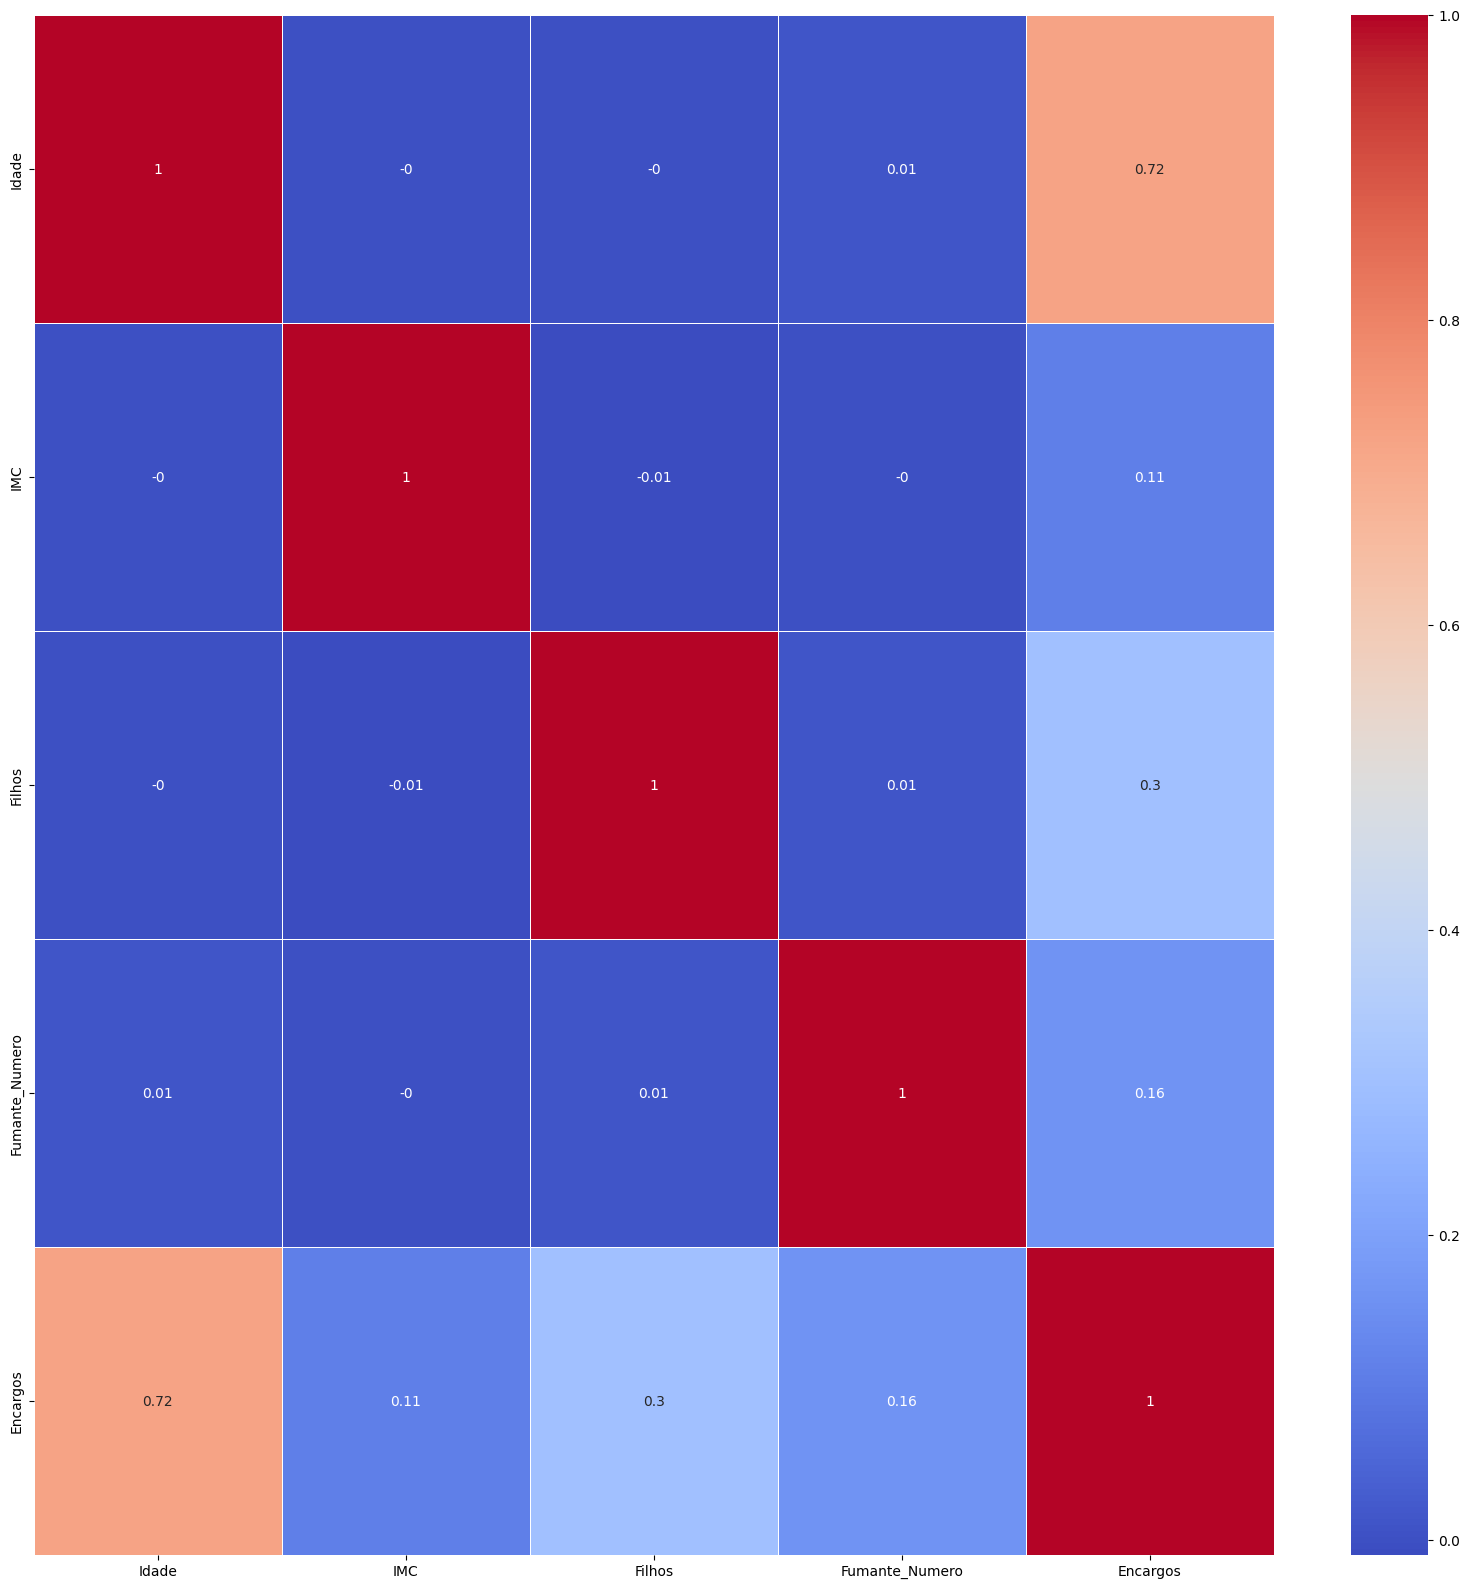

In [9]:
numeric_columns = dados.select_dtypes(include='number')

correlation_matrix = numeric_columns.corr().round(2)

fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax, cmap="coolwarm")

# Removendo a coluna Fumante_Numero, não mais necessária (coluna Fumante mantida)
dados.drop(columns=['Fumante_Numero'], inplace=True)

**Identificação de Outliers:** 

<Axes: >

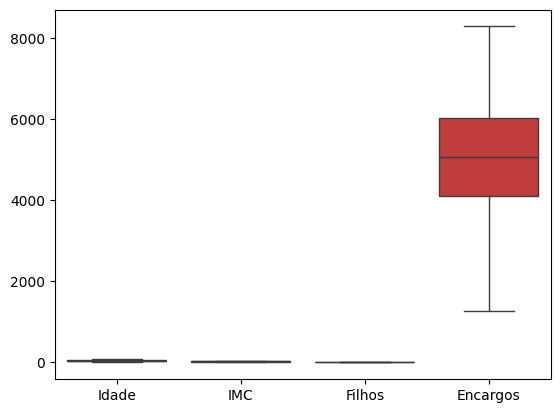

In [10]:
# Loop sobre as colunas
for coluna in dados.columns:
    # Quartis só funcionam em colunas numéricas
    if dados[coluna].dtype in ['int64', 'float64']:
        # Calcular os quartis para a coluna atual
        quartis = dados[coluna].quantile([0.25, 0.75])
        
        # Calcular o intervalo interquartil (IQR)
        iqr = quartis[0.75] - quartis[0.25]
        
        # Definir limites para identificar outliers
        limite_inferior = quartis[0.25] - 1.5 * iqr
        limite_superior = quartis[0.75] + 1.5 * iqr
        
        # Marcar os outliers como NaN
        dados['outlier_mask_' + coluna] = ((dados[coluna] < limite_inferior) | (dados[coluna] > limite_superior)).astype(int)
        dados[coluna] = dados[coluna].mask(dados['outlier_mask_' + coluna] == 1)

# Salvar os dados com os outliers
dados.to_csv("../planilhas/7_dados_com_outliers.csv", index=False, encoding='latin1')
        
# Remover colunas de máscara de outliers
dados.drop(columns=[col for col in dados.columns if 'outlier_mask_' in col], inplace=True)

# Plotar boxplot
sns.boxplot(data=dados)

**Visualizações Gráficas:** Visualizações gráficas para entender a distribuição e relacionamentos entre as variáveis

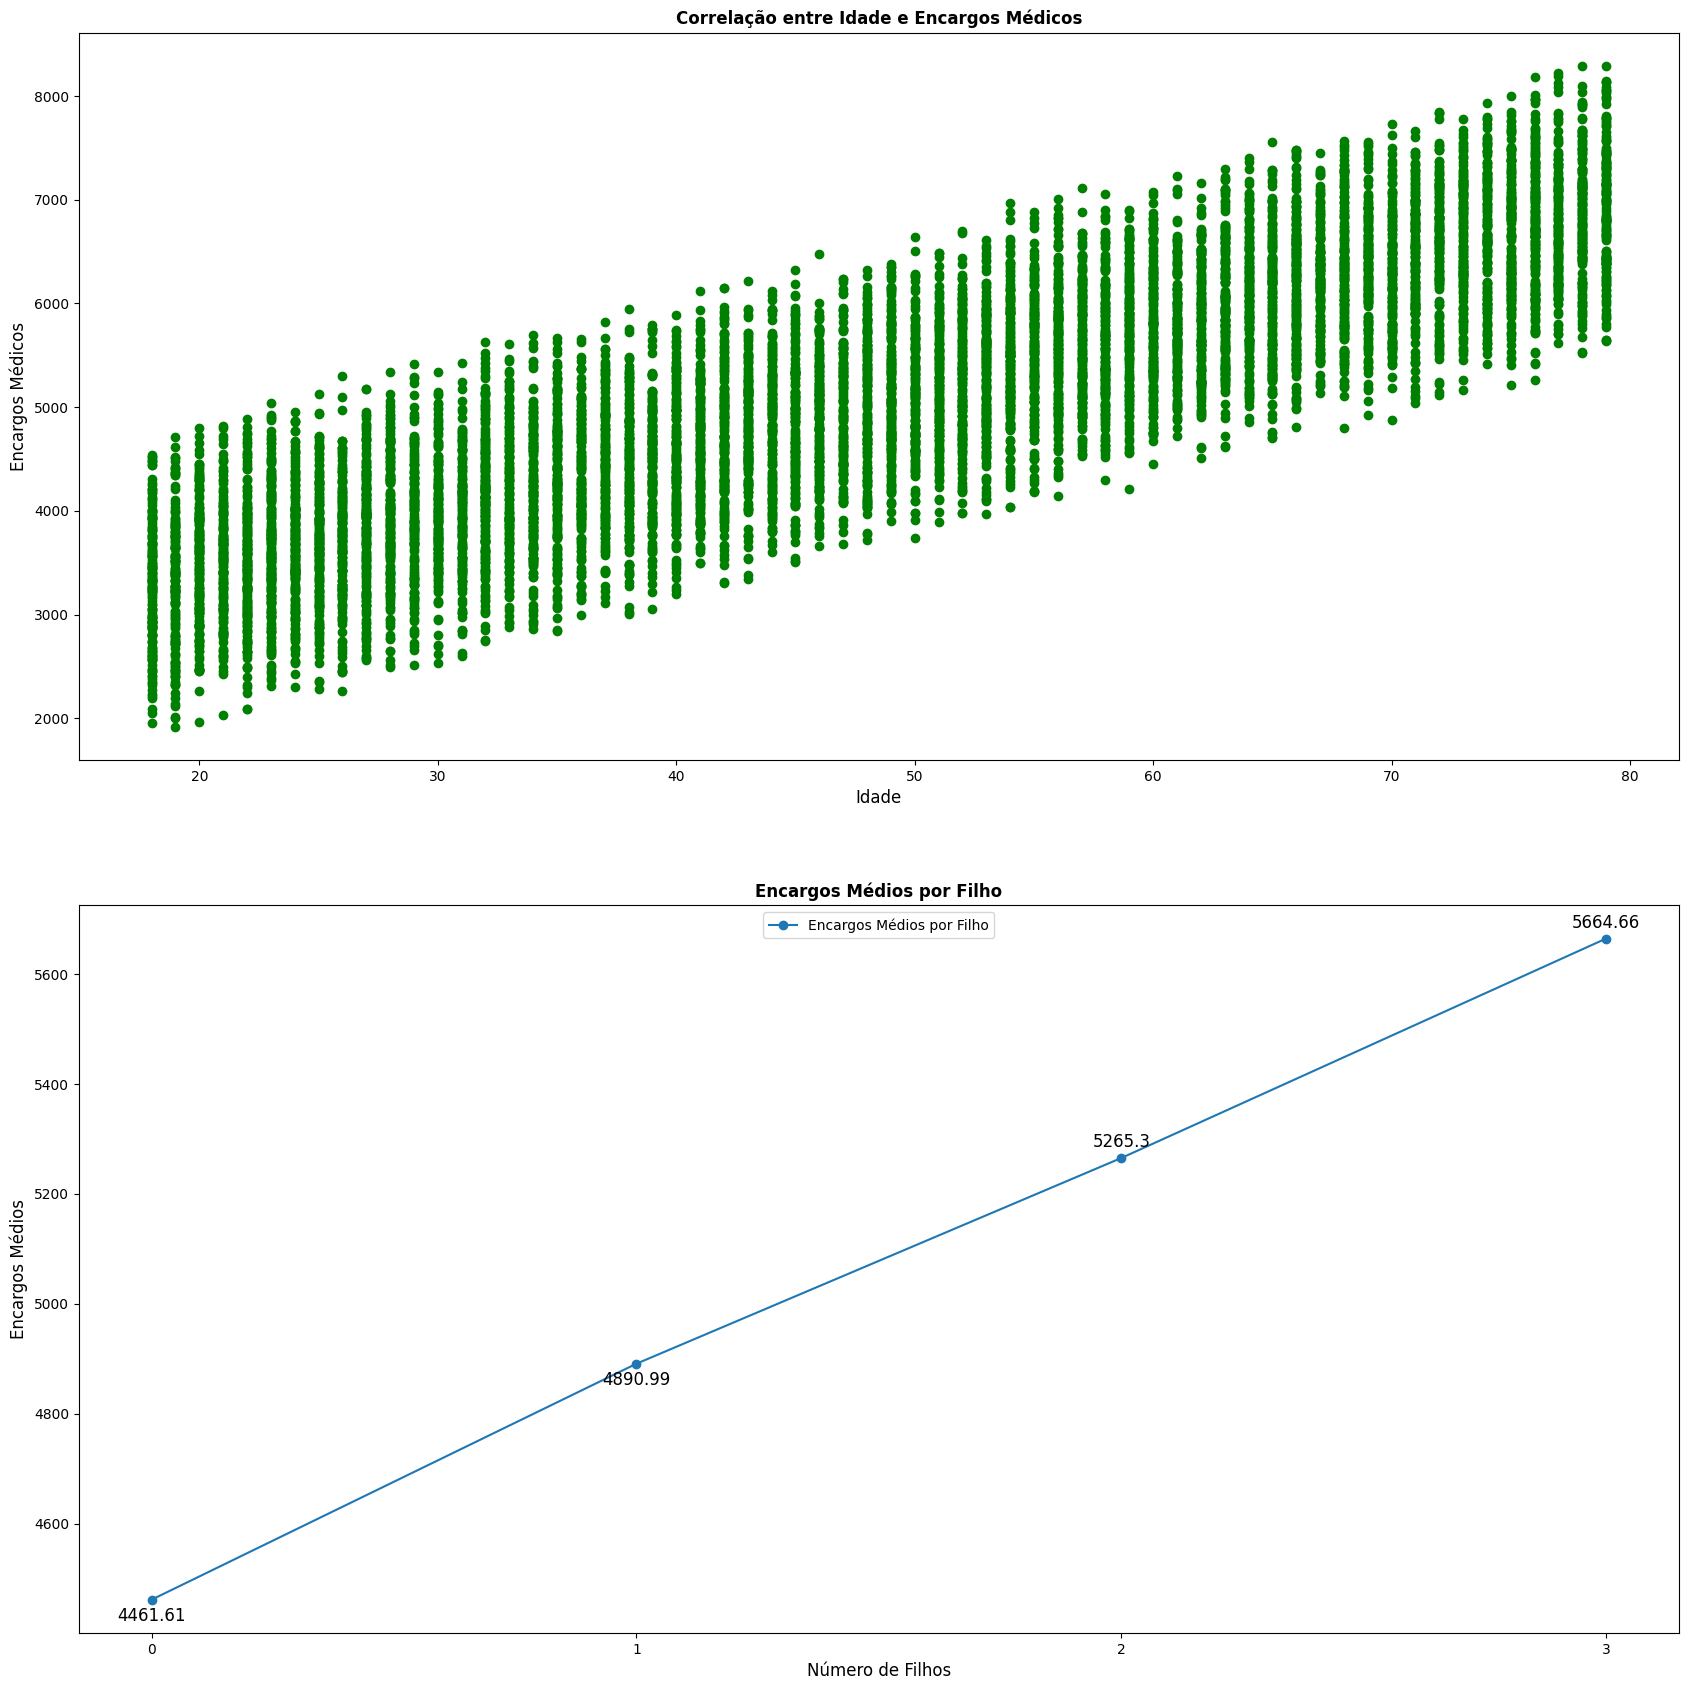

In [11]:
montar_graficos_relacionamento_encargos(dados)